# <center><ins>REIT Time Series Analysis(Ticker: AMT)<ins/><center/>

In [6]:
from module import decomposition
from module import dickey_fuller
from module import arima_endog
from module import arima_exog
from module import rmse_cv
from module import lasso_reg

import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from numpy import hstack
import warnings
import os
from fredapi import Fred
warnings.filterwarnings('ignore')

import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf


%matplotlib inline
%load_ext autoreload
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
start = datetime(2000,2,1)
end = datetime(2020,1,31)

In [9]:
AMT = web.DataReader('AMT', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
AMT = AMT.copy()
AMT.to_csv('data/AMT_gru')
AMT.index = pd.to_datetime(AMT.index)
AMT = AMT.resample('MS').mean()
AMT['mid'] = (AMT['high']+AMT['low'])/2
AMT.drop(labels = ['high', 'low', 'open', 'close', 'volume'], axis = 1, inplace = True)
AMT.to_csv('data/mid_prices/AMT_mid.csv')

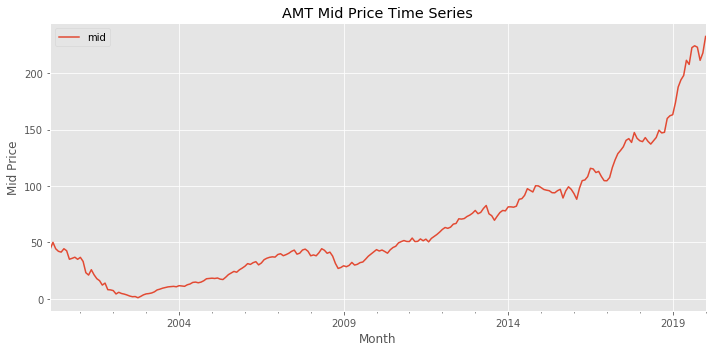

In [4]:
plt.style.use('ggplot')
AMT.plot(figsize = (10,5))
plt.xlabel('Month')
plt.ylabel('Mid Price')
plt.title('AMT Mid Price Time Series')
plt.tight_layout()
plt.show();

## <ins>Time Series Decomposition<ins/>

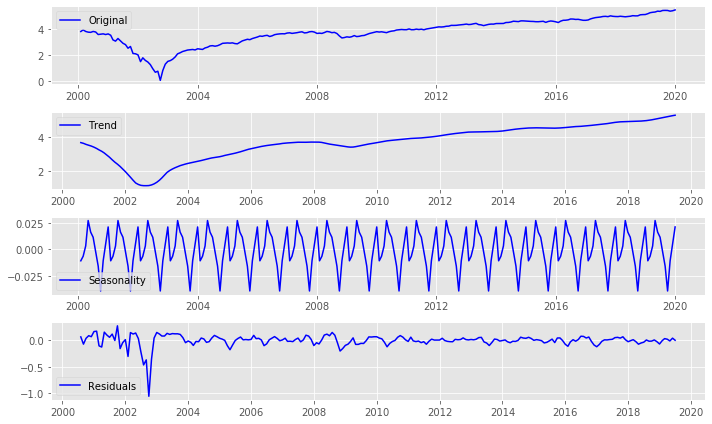

In [5]:
decomposition(AMT)

In [6]:
AMT_diff = AMT.diff(periods = 1).dropna()

In [7]:
dickey_fuller(AMT_diff)

The series passes the Dickey Fuller Test for Stationarity. P-Value = 1.2335091984903194e-05


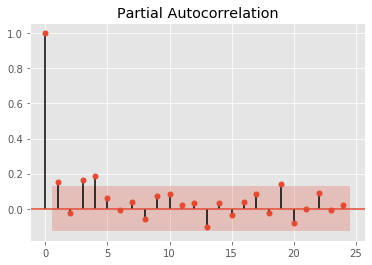

In [8]:
plot_pacf(AMT_diff);

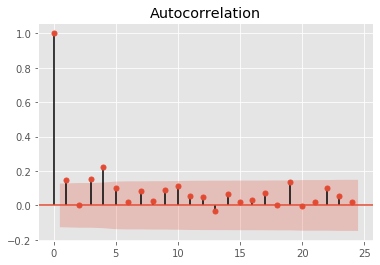

In [9]:
plot_acf(AMT_diff);

In [10]:
parameters = (11,1,2)
seasonal_parameters = (11,1,2,12)

In [11]:
AMT_train = AMT[:'2017']
AMT_test = AMT['2018':]

## <ins>SARIMAX Model w/o Exogenous Variables<ins/>

Summary:                                   Statespace Model Results                                  
Dep. Variable:                                  mid   No. Observations:                  215
Model:             SARIMAX(11, 1, 2)x(11, 1, 2, 12)   Log Likelihood                -153.751
Date:                              Wed, 12 Feb 2020   AIC                            363.501
Time:                                      10:41:45   BIC                            421.672
Sample:                                  02-01-2000   HQIC                           386.209
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0050      0.017      0.289      0.772      -0.029       0.039
ar.L1     

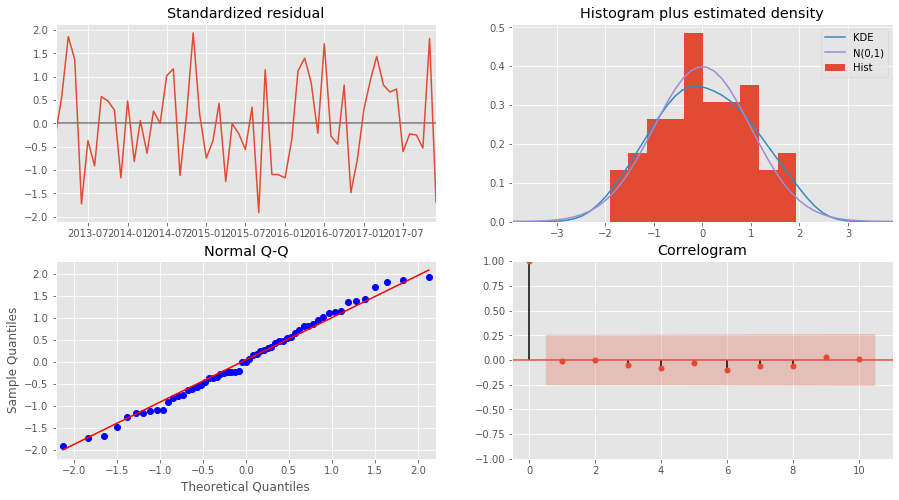

--------------------------------------------------------------------------------------------------------------------------------------------------------------
 
Predictions vs. Observed: 
 


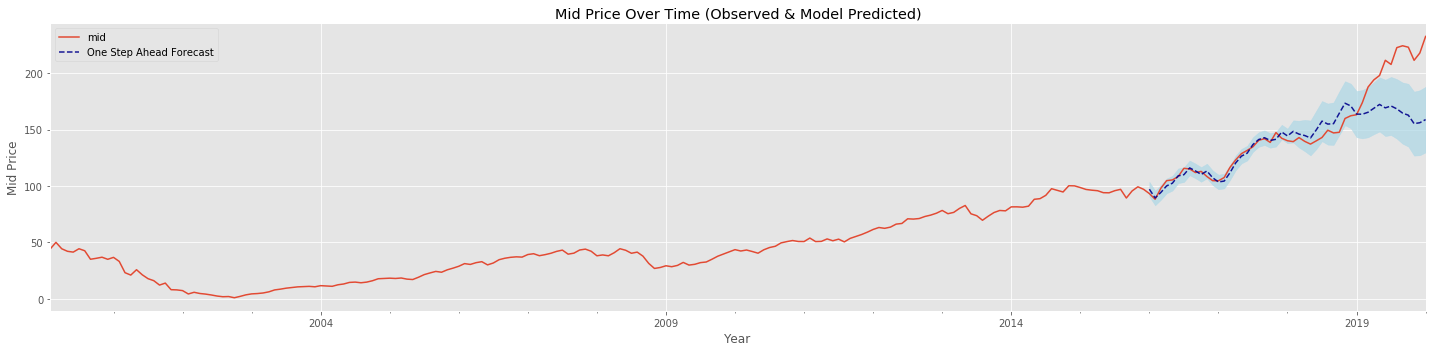

In [12]:
arima_endog(AMT_train, AMT, parameters, seasonal_parameters)

## <ins>Determine Exogenous Feature Importance<ins/>

In [13]:
AMT_rates = pd.read_csv('data/AMT_rates.csv', index_col = 'date')

The R-score of the Lasso Regression is: 0.9889717801393691



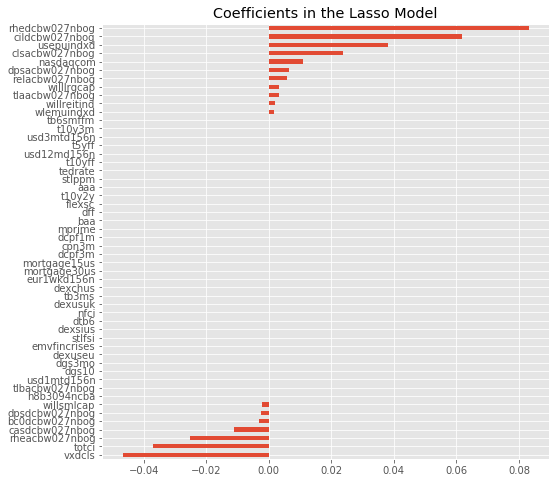

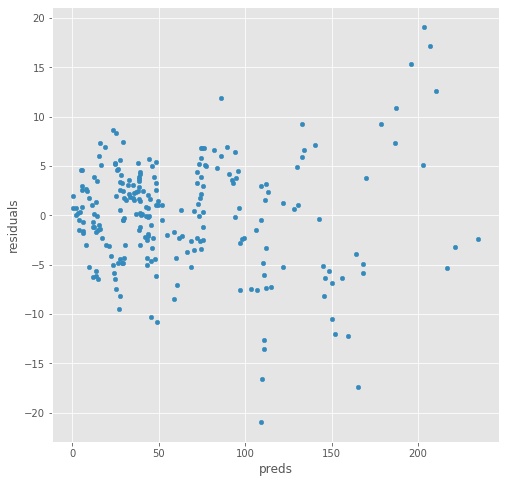

In [14]:
lasso_reg(AMT_rates)

In [15]:
AMT_rates_train = AMT_rates[:'2018']
AMT_rates_test = AMT_rates['2018':]

In [19]:
exog_train = AMT_rates_train[['rhedcbw027nbog', 'cildcbw027nbog', 'usepuindxd', 'clsacbw027nbog', 'vxdcls', 'totci', 'rheacbw027nbog', 'casdcbw027nbog']]

In [20]:
exog_test = AMT_rates_test[['rhedcbw027nbog', 'cildcbw027nbog', 'usepuindxd', 'clsacbw027nbog', 'vxdcls', 'totci', 'rheacbw027nbog', 'casdcbw027nbog']]

## <ins>SARIMAX Model w/ Exogenous Variables<ins/>

Summary:                                   Statespace Model Results                                  
Dep. Variable:                                  mid   No. Observations:                  215
Model:             SARIMAX(11, 1, 2)x(11, 1, 2, 12)   Log Likelihood                -140.269
Date:                              Wed, 12 Feb 2020   AIC                            352.537
Time:                                      10:53:31   BIC                            427.329
Sample:                                  02-01-2000   HQIC                           381.733
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
drift              0.0180      0.062      0.290      0.771      -0.104       0.14

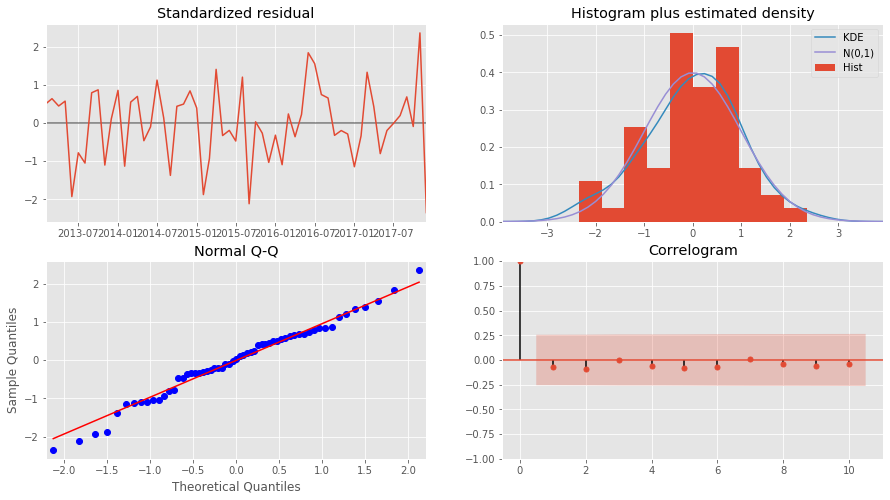

--------------------------------------------------------------------------------------------------------------------------------------------------------------
 
Predictions vs. Observed: 
 


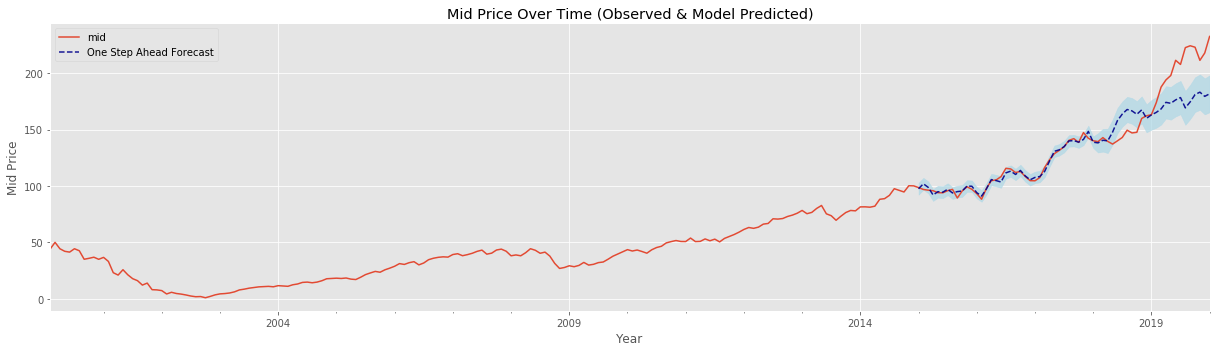

In [21]:
arima_exog(AMT_train, AMT, parameters, seasonal_parameters, exog_train, exog_test)